In [1]:
# Library imports
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helper import print_results, metis_map

# Prunning Youtube Network for Analysis

In [ ]:
youtubeG = nx.read_edgelist("data/com-youtube.ungraph.txt", create_using = nx.Graph, nodetype = int)

The next cell will make the youtube network much smaller so we can 

In [ ]:

# Obtains list of degrees that have degree less than 3
degree_Thres = 6
remove = [node for node,degree in dict(youtubeG.degree()).items() if  degree < degree_Thres]

# Removes nodes with small degree and creates sparse matrix
youtubeG.remove_nodes_from(remove)
nx.write_edgelist(youtubeG,'youtube_sparse.txt', data=False)


# Cluster Analysis

### Data Imports
Load in every graph. We'll look at some simple metrics to get some baseline understanding.

In [2]:
wikiG = nx.read_edgelist("input/wiki-Vote.txt", create_using = nx.Graph, nodetype = int)
collabG = nx.read_edgelist("input/ca-GrQc.txt", create_using = nx.Graph, nodetype = int)
p2pG = nx.read_edgelist("input/p2p-Gnutella08.txt", create_using = nx.Graph, nodetype = int)
fbG = nx.read_edgelist("input/facebook_combined.txt", create_using = nx.Graph, nodetype = int)
youtubeG = nx.read_edgelist("input/com-youtube.ungraph.txt", create_using = nx.Graph, nodetype = int)

pd.DataFrame({"Graph": ["Wikipedia", "Collaborations", "Gnutella", "Facebook", "Youtube"],
    "Node Count": [wikiG.number_of_nodes(), collabG.number_of_nodes(), p2pG.number_of_nodes(), fbG.number_of_nodes(), youtubeG.number_of_nodes()],
    "Edge Count": [wikiG.number_of_edges(), collabG.number_of_edges(), p2pG.number_of_edges(), fbG.number_of_edges(), youtubeG.number_of_edges()]})

,Graph,Node Count,Edge Count
0,Wikipedia,7115,100762
1,Collaborations,5242,14496
2,Gnutella,6301,20777
3,Facebook,4039,88234
4,Youtube,1134890,2987624


We use the following code to find a mapping between our Node_IDs from our original text files to our Node_IDs in the METIS files. Note that all helper functions can be found in helper.py.

In [4]:
names = ["wiki-Vote", "p2p-Gnutella08", "facebook_combined", "ca-GrQc", "com-youtube.ungraph"]

In [ ]:
for i in names:
    fname = "input/" + i + ".txt"
    obj_fname = "MetisAlgo/" + i + "_map.obj"
    metis_map(fname, obj_fname)

We need to check if we pulled our clustering data properly. Let's look at the accuracy assuming that the Clauset-Newman-Moore algorithm is the ground truth.

In [ ]:
from sklearn import metrics
metrics.accuracy_score([0, 0, 0], [1, 1, 1])

In [ ]:
wiki_m = np.loadtxt("output/wiki-Vote.metis.part.100")
mmap, mlist = get_map(name)
cluster_data = np.loadtxt('output/' + "wiki-Vote" + '_community.txt', dtype = int)
cluster_map = {i[0]: i[1] for i in cluster_data}
clustering = [cluster_map[mlist[i]] for i in range(len(mlist))]

### Wiki-Vote

Now we'll pull the three metrics (modularity, ncut, and condunctance) for clusterings without ground truth. We can get a good idea for how well each algorithm was able to group nodes with high edge density together.

In [5]:
name = names[0]
mcl = print_results(wikiG, name, "mcl")
metis = print_results(wikiG, name, "metis")
community = print_results(wikiG, name, "community")

According to modularity, it seems as though the Clauset-Newman-Moore algorithm performed the best. As we can recall from Lab 1, the Wikipedia Vote network was our only directed graph. Unfortunately, none of our clustering algorithms were compatible with this information, so we had to treat it as undirected.

Note that modularity is biased towards algorithms with a small number of clusters. MCL is biased towards fragmenting the clusters into a large number of clusters, thus modularity might not represent the true performance.

In [6]:
print("Modularity of MCL:", mcl.Modularity[0])
print("Modularity of METIS:", metis.Modularity[0])
print("Modularity of Communities:", community.Modularity[0])

Modularity of MCL: 0.01080145681798467
Modularity of METIS: 0.004638421479492384
Modularity of Communities: 0.35004242922498335


Let's look back at our data from Lab 1. Recall that our largest Weakly Connected Component had a size of 7066, which is only slightly smaller than our graph. It also seems as though only a small percentage of nodes receives a majority of votes. This can be seen in the histogram below where most nodes have very low closeness centrality whereas there's a small group which likely receives all the votes.

array([[<AxesSubplot: title={'center': 'closeness'}>]], dtype=object)

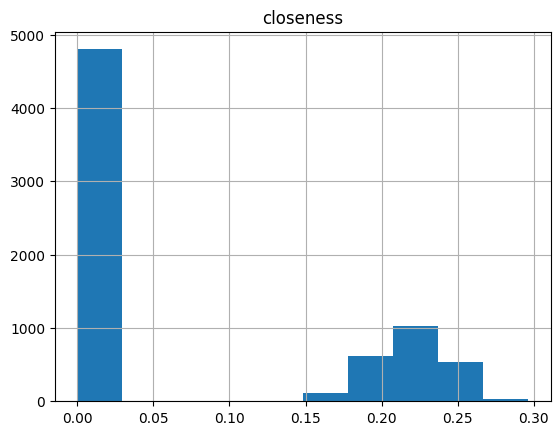

In [15]:
pd.read_csv('lab1_results/wiki-Vote.csv').hist(column = "closeness")

Let's now take a look at the distributions for conductance and ncut. In looking at the correlation between n-cut and conductance, we can see  that both metrics return the same values almost all of the time across our three algorithms. We'll just take a look at conductance here on out (when looking at Wikipedia Network).

In [36]:
print("MCL:", np.corrcoef(mcl['n-cut'], mcl['Conductance'])[0, 1])
print("METIS:", np.corrcoef(metis['n-cut'], metis['Conductance'])[0, 1])
print("Community:", np.corrcoef(community['n-cut'], community['Conductance'])[0, 1])

MCL: 1.0
METIS: 1.0
Community: 0.9997321655001824


Below, we will compute the mean conductance for each of our three algorithms.

In [43]:
print("MCL:", mcl['Conductance'].mean())
print("METIS:", metis['Conductance'].mean())
print("Community:", community['Conductance'].mean())

MCL: 0.9965174216840647
METIS: 0.9938110094103872
Community: 0.34456986372497184


It is apparent that the Clauset-Newman-Moore algorithm performed the best. Our mean conductance score tells us that on average, clusters retained 66% of their edges going inwards whereas only 34% of edges went outwards. The histogram below shows that it was able to get extremely low conductance on over 20 different clusters. Additionally, it achieved moderate results on several fringe clusters.

<AxesSubplot: >

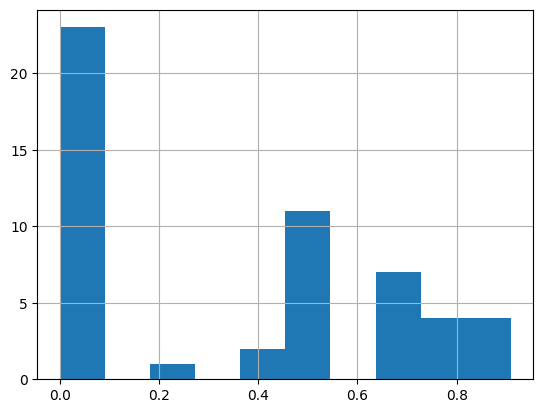

In [44]:
community['Conductance'].hist()

### Peer-To-Peer Filesharing

Next we'll take a look at the three metrics for clusterings our P2P Filesharing network (still no ground truth).

In [5]:
name = names[1]
mcl = print_results(p2pG, name, "mcl")
metis = print_results(p2pG, name, "metis")
community = print_results(p2pG, name, "community")

Again, the modularity was much higher for the Communities algorithm. Recall that modularity has a range of [-1/2, 1]. The fact that we're achieving positive results is good. However, we should dive into the clusterings to assess true model performance.

In [6]:
print("Modularity of MCL:", mcl.Modularity[0])
print("Modularity of METIS:", metis.Modularity[0])
print("Modularity of Communities:", community.Modularity[0])

Modularity of MCL: 0.0061866716778662696
Modularity of METIS: 0.007280697160582582
Modularity of Communities: 0.46470269904474426


To decide if we should focus on n-cut or conductance, we can look at the correlation between them. For all three algorithms, the values are always the same. Thus, we'll just look at conductance for simplicity.

In [7]:
print("MCL:", np.corrcoef(mcl['n-cut'], mcl['Conductance'])[0, 1])
print("METIS:", np.corrcoef(metis['n-cut'], metis['Conductance'])[0, 1])
print("Community:", np.corrcoef(community['n-cut'], community['Conductance'])[0, 1])

MCL: 1.0
METIS: 1.0
Community: 1.0


Similar to what we saw with the Wikipedia Vote Network, our P2P Filesharing Network was clustered much better by the Clauset-Newman-Moore algorithm. On average, 44% of edges belonging to an arbitrary cluster C were directed to another node in C. This is much better than the MCL and METIS algorithms which have less than 1% of edges returning to within the cluster.

In [8]:
print("MCL:", mcl['Conductance'].mean())
print("METIS:", metis['Conductance'].mean())
print("Community:", community['Conductance'].mean())

MCL: 0.9957944398709978
METIS: 0.9912211240553711
Community: 0.5568492413129087


### Facebook

In [31]:
name = names[2]
mcl = print_results(fbG, name, "mcl")
metis = print_results(fbG, name, "metis")
community = print_results(fbG, name, "community")

Below are the modularities for our three algorithms. This case is quite interesting, as the modularity of the MCL algorithm is highest we've seen for MCL at 0.1 and the modularity of communities algorithm is the highest we've seen overall 0.78. This means that the number of edges within communities is significantly higher than expected.

Note that the type of graph has a lot of social circles. There are 1,612,010 triangles in the FB graph, over double the number of triangles in the Wikipedia Vote Network, even though FB Network has less nodes and edges. This interconnectedness allows for the Communities algorithm to have such high modularity even though we typically say that 0.3 to 0.7 is the range for well structured networks.

In [32]:
print("Modularity of MCL:", mcl.Modularity[0])
print("Modularity of METIS:", metis.Modularity[0])
print("Modularity of Communities:", community.Modularity[0])

Modularity of MCL: 0.10101223381157409
Modularity of METIS: 0.02213859078723416
Modularity of Communities: 0.7753974289288965


Next, when we look at conductance, it is very low for the Community algorithm as on average 82% of edges are returned to the same community.

In [33]:
print("MCL:", mcl['Conductance'].mean())
print("METIS:", metis['Conductance'].mean())
print("Community:", community['Conductance'].mean())

MCL: 0.9850017599659476
METIS: 0.978996543351725
Community: 0.17500072276861905


It might be helpful to look into the number of clusters generated by each algorithm. Recall that the METIS algorithm has always given us 100 clusters. Looking at MCL and Communities we can see that they have many more clusters. Given the structure of an expansive social media network, METIS likely failed due to this low number of clusters.

### Collaborations

In [ ]:
collab = np.loadtxt("input/ca-GrQc.txt", dtype = int)
for i in collab:
    if i[0] == i[1]:
        print(i)

In [ ]:
for c in nx.connected_components(collabG):
    if len(c) == 1:
        print(c)

Our collaborations network reports an error when including node_id = 12295. It has one self-edge and is part of a one-node component as seen above meaning that it is connected to no other nodes. We have to remove this node and handle a couple of special cases for our metrics to run.

In [ ]:
collabG.remove_nodes_from([12295])
mcl = print_results(collabG, names[3], "mcl")
metis = print_results(collabG, names[3], "metis")

### Youtube

In [36]:
metis = print_results(youtubeG, names[4], "metis")

In [38]:
mcl = print_results(youtubeG, names[4], "mcl")

In [ ]:
metis.to_csv('output/youtube_metis_results.csv')
mcl.to_csv('output/youtube_mcl_results.csv')